In [1]:
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib.colors import hsv_to_rgb

from pprint import pprint
import os
import json
import itertools

from tqdm import tqdm
import numpy as np

from dpipe.config import get_resource_manager
from dpipe.medim.visualize import slice3d
from dpipe.medim.metrics import multichannel_dice_score
from dpipe.dataset.brats import Brats2017
from dpipe.dataset.wrappers import bbox_extraction, normalized

from sklearn.metrics import confusion_matrix

In [3]:
dataset = bbox_extraction(Brats2017('/cobrain/groups/ml_group/data/brats2017/train/'))

In [5]:
p = dataset.ids[1]

x = dataset.load_image(p)
segm = dataset.load_segm(p)

In [6]:
def normalize(image):
    normalized = image - image.min()
    return normalized / normalized.max()

def hsv_gray_image(intensitive):
    hsv = np.zeros((*intensitive.shape, 3))
    hsv[..., 2] = normalize(intensitive)
    return hsv

def hsv_apply_color_mask(image, mask, color, color_value=None):
    assert np.issubdtype(mask.dtype, bool)
    image = image.copy()
    shape = image.shape
    
    mask = mask.flatten()
    image_flatten = image.reshape((-1, 3))
    
    image_flatten_masked = image_flatten[mask]
    
    image_flatten_masked[..., 0] = color
    image_flatten_masked[..., 1] = 1
    if color_value is not None:
        image_flatten_masked[..., 2] = color_value
    image_flatten[mask] = image_flatten_masked
    
    return image_flatten.reshape(shape)

In [7]:
marked_x = []

for modality in x:
    image = hsv_gray_image(modality)
    image = hsv_apply_color_mask(image, segm == 1, 0.0, color_value=1)
    image = hsv_apply_color_mask(image, segm == 2, 0.33, color_value=1)
    image = hsv_apply_color_mask(image, segm == 3, 0.66, color_value=1)
    marked_x.append(hsv_to_rgb(image))

slice3d(*x, *marked_x, axis=2, max_columns=4)

interactive(children=(IntSlider(value=0, continuous_update=False, description='idx', max=131), Output()), _dom_classes=('widget-interact',))

In [39]:
experiment_path = '/home/krivov/new_exp/brats_spatial_deepmedic_els/experiment_0/'

predictions_path = os.path.join(experiment_path, 'test_segm_pred_prob')
msegm_path = os.path.join(experiment_path, 'test_msegm_pred')


patients = [p.replace('.npy', '') for p in os.listdir(predictions_path)]

[0.87072889866622261, 0.4482955355869348, 0.25322703113135914]


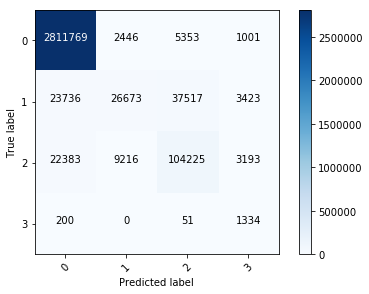

In [40]:
p = patients[1]

mscan = dataset.load_x(p)
segm_pred = np.load(os.path.join(predictions_path, p + '.npy'))
msegm_pred = np.load(os.path.join(msegm_path, p + '.npy'))

segm_true = dataset.load_segm(p)
msegm_true = dataset.load_msegm(p)

print(multichannel_dice_score(msegm_pred, msegm_true))

cm = confusion_matrix(segm_true.flatten(),
                      np.argmax(segm_pred, axis=0).flatten())

#cm[0, 0] = 0

plot_confusion_matrix(cm, normalize=False, classes=np.unique(segm_true))

msegm_pred[:, 0, 0, [0, -1]] = 0, 1
msegm_true[:, 0, 0, [0, -1]] = 0, 1
segm_pred[:, 0, 0, [0, -1]] = 0, 1

In [43]:
hsv = hsv_gray_image(mscan[2])
hsv[..., 1] = msegm_pred[1]
hsv[..., 2] = 0.5

slice3d(hsv_to_rgb(hsv), axis=-2)

interactive(children=(IntSlider(value=0, continuous_update=False, description='idx', max=133), Output()), _dom_classes=('widget-interact',))

In [41]:
slice3d(*mscan,
        ~np.any(msegm_true, axis=0), *msegm_true,
        ~np.any(msegm_pred, axis=0), *msegm_pred, *segm_pred, max_columns=4)

interactive(children=(IntSlider(value=0, continuous_update=False, description='idx', max=133), Output()), _dom_classes=('widget-interact',))

In [7]:
slices = [slice(None)] + [slice(1, -1, 9)] * 3

mscan_d = mscan[slices]
segm_pred_d = segm_pred[slices]
msegm_true_d = msegm_true[slices]
msegm_pred_d = msegm_pred[slices]

In [8]:
mscan.shape

(4, 132, 175, 139)

In [9]:
slice3d(*mscan_d,
        ~np.any(msegm_true_d, axis=0), *msegm_true_d,
        ~np.any(msegm_pred_d, axis=0), *msegm_pred_d, *segm_pred_d, max_columns=4)

interactive(children=(IntSlider(value=0, continuous_update=False, description='idx', max=15), Output()), _dom_classes=('widget-interact',))

In [8]:
p = patients[0]

In [9]:
p.replace('.npy', '')

'Brats17_TCIA_167_1'

In [4]:
slice3d(*x, ~y.any(axis=0), *y, max_columns=4)

interactive(children=(IntSlider(value=0, continuous_update=False, description='idx', max=131), Output()), _dom_classes=('widget-interact',))